In [ ]:
import os, glob, datetime, time, re
import shutil, random, math
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from prettytable import PrettyTable
from matplotlib import pyplot as plt

import scipy.io
import numpy as np
import seaborn as sns
import plotly.express as px
import streamlit as st
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

%matplotlib inline

In [ ]:
def SEED():
  seed = 123789 # Internation fixed number of seed...
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['PYTHONHASHSEED'] = str(seed)

# Matrix Index
-  PSNR: Peak signal to noise ratio
-  SSIM: Structural index similarity
-  SAM: Spectral Angle Mapper

In [ ]:
SEED()
def sam(x_true, x_pred):
    assert x_true.ndim ==3 and x_true.shape == x_pred.shape
    h,w,c=x_pred.shape
    sam_rad = []
    for x in range(x_true.shape[0]):
        for y in range(x_true.shape[1]):
            tmp_pred = x_pred[x, y].ravel()
            tmp_true = x_true[x, y].ravel()
            s = np.sum(np.dot(tmp_pred, tmp_true))
            t = (np.sqrt(np.sum(tmp_pred ** 2))) * (np.sqrt(np.sum(tmp_true ** 2)))
            th = np.arccos(s/t)
            sam_rad.append(th)
    sam_deg = np.mean(sam_rad)
    return sam_deg

def quantitative_assess(data_clean,test_out):
    psnrs=[]
    ssims=[]
    height,width,band =data_clean.shape
    for b in range(band):
        psnr1 = peak_signal_noise_ratio(data_clean[:, :, b], test_out[:, :, b],data_range=1)
        ssim1 = structural_similarity(data_clean[:, :, b], test_out[:, :, b],win_size=11,data_range=1,gaussian_weights=1)
        psnrs.append(psnr1)
        ssims.append(ssim1)
    avg_psnr = np.mean(psnrs)
    avg_ssim = np.mean(ssims)
    Sam=sam(data_clean,test_out)
    return [avg_psnr,avg_ssim,Sam]

# Spatial and Channel (Spectral) Attention Modules

In [ ]:
SEED()
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Geometrical Characteristics Features Extraction Modules
-  Spatial Feature Extraction Module
-  Multiscale Separable Spectral Feature Extraction Module

In [ ]:
SEED()
class Geometrical_Characteristics(nn.Module):
  def __init__(self, input_Channel=None, feature_Channel=None, K=None):
    super(Geometrical_Characteristics, self).__init__()

    self.Spatial_Feature_3 = nn.Sequential(
        nn.Conv2d(input_Channel, feature_Channel, 3, padding=1),
    )
    self.Spatial_Feature_5 = nn.Sequential(
        nn.Conv2d(input_Channel, feature_Channel, 5, padding=2),
    )
    self.Spatial_Feature_7 = nn.Sequential(
        nn.Conv2d(input_Channel, feature_Channel, 7, padding=3),
    )

    self.Spectral_Feature_3 = nn.Sequential(
        nn.Conv3d(1, feature_Channel, (K, 1, 1), 1, (0, 0, 0)),
        nn.Conv3d(feature_Channel, feature_Channel, (1, 3, 3), 1, (0, 1, 1))
    )
    self.Spectral_Feature_5 = nn.Sequential(
        nn.Conv3d(1, feature_Channel, (K, 1, 1), 1, (0, 0, 0)),
        nn.Conv3d(feature_Channel, feature_Channel, (1, 5, 5), 1, (0, 2, 2))
    )
    self.Spectral_Feature_7 = nn.Sequential(
        nn.Conv3d(1, feature_Channel, (K, 1, 1), 1, (0, 0, 0)),
        nn.Conv3d(feature_Channel, feature_Channel, (1, 7, 7), 1, (0, 3, 3))
    )

  def forward(self, Spatial, Spectral):
    Spatial_3 = self.Spatial_Feature_3(Spatial)
    Spatial_5 = self.Spatial_Feature_5(Spatial)
    Spatial_7 = self.Spatial_Feature_7(Spatial)

    Spectral_3 = self.Spectral_Feature_3(Spectral)
    Spectral_5 = self.Spectral_Feature_5(Spectral)
    Spectral_7 = self.Spectral_Feature_7(Spectral)

    spatial = F.leaky_relu(torch.cat((Spatial_3, Spatial_5, Spatial_7), dim=1))
    spectral = F.leaky_relu(torch.cat((Spectral_3, Spectral_5, Spectral_7), dim=1)).squeeze(2)
    spatial_spectral = torch.cat((spatial, spectral), dim=1)

    return spatial_spectral

# Attention and Adjacent Features Extraction Hybrid Dense Network (AAFEHDN)

### Decompose Frequency (High and Low)

In [ ]:
SEED()

# Attentive Skip Connection (High and Low Frequency Features)
class ASC(nn.Module):
  def __init__(self, channel):
    super().__init__()
    self.weight = nn.Sequential(
        nn.Conv2d(channel * 2, channel, 1),
        nn.LeakyReLU(),
        nn.Conv2d(channel, channel, 3, 1, 1),
        nn.Sigmoid()
    )

  def forward(self, x, y):
    w = self.weight(torch.cat([x, y], dim=1))
    out = (1 - w) * x + w * y
    return out

# Progressive Spectral Channel Attention (PSCA)
class PSCA(nn.Module):
  def __init__(self, channel, channel_half):
    super().__init__()
    self.w_1 = nn.Conv2d(channel, channel_half, 1, bias=False)
    self.w_2 = nn.Conv2d(channel_half, channel, 1, bias=False)
    self.w_3 = nn.Conv2d(channel, channel, 1, bias=False)
    nn.init.zeros_(self.w_3.weight)

  def forward(self, x):
    x = self.w_3(x) * x + x
    x = self.w_1(x)
    x = F.gelu(x)
    x = self.w_2(x)
    return x

In [ ]:
# data = torch.randn(1, 80, 200, 200)
# model = ASC(80)
# output = model(data, data)
# output.shape

In [ ]:
# data = torch.randn(1, 80, 200, 200)
# model = PSCA(80, 80//2)
# output = model(data)
# output.shape

### Denoising Block (AAFEHDN) Network

In [ ]:
SEED()
class AAFEHDN_block(nn.Module):
    def __init__(self,block_num=None, channel=None):
        super(AAFEHDN_block,self).__init__()
        self.group_list_asc_model = []
        self.group_list_psca_model = []
        channel_half = int(channel//2)
        self.block_number = block_num

        for i in range(0, block_num-1):
          asc_model = ASC(channel)
          self.add_module(name='asc_model_%d' % i, module=asc_model)
          self.group_list_asc_model.append(asc_model)

          psca_model = PSCA(channel, channel_half)
          self.add_module(name='psca_model_%d' % i, module=psca_model)
          self.group_list_psca_model.append(psca_model)

        self.channel_attention = ChannelAttention(channel)
        self.spatial_attention = SpatialAttention(7)

    def forward(self, input):
      output_feature = [input]
      updated_feature = input
      for index in range(0, self.block_number-1):
        asc_model_group1 = self.group_list_asc_model[index](updated_feature, updated_feature)
        channel_attention_asc = self.channel_attention(asc_model_group1) * asc_model_group1
        spatial_attention_asc = self.spatial_attention(channel_attention_asc) * channel_attention_asc + input

        psca_model_group2 = self.group_list_psca_model[index](spatial_attention_asc)
        channel_attention_psca = self.channel_attention(psca_model_group2) * psca_model_group2
        spatial_attention_psca = self.spatial_attention(channel_attention_psca) * channel_attention_psca + input

        output_feature.append(spatial_attention_psca)
        updated_feature = spatial_attention_psca + input

      concat = torch.cat(output_feature, dim=1)
      return concat

In [ ]:
# data = torch.randn(1, 80, 200, 200)
# model = AAFEHDN_block(block_num=6, channel=80)
# output = model(data)
# output.shape

In [ ]:
SEED()
class AAFEHDN(nn.Module):
    def __init__(self, input_Channel=1, block_num=3, K=24, feature_Channel=20, layer_output=80):
        super(AAFEHDN, self).__init__()
        self.geometricalCharacter = Geometrical_Characteristics(input_Channel, feature_Channel, K)
        self.ca_in = ChannelAttention(feature_Channel * 6)
        self.sa_in = SpatialAttention(7)
        self.concat_in = nn.Conv2d(feature_Channel * 6, layer_output, 3, 1, padding=1)
        self.AAFEHDN_block = AAFEHDN_block(block_num=block_num, channel=layer_output)
        self.FR = nn.Conv2d(layer_output*block_num, input_Channel, 3, 1, padding=1)

    def forward(self, Spatial, Spectral):
        spatial_spectral = self.geometricalCharacter(Spatial, Spectral)
        ca_in = self.ca_in(spatial_spectral) * spatial_spectral
        sa_in = self.sa_in(ca_in) * ca_in
        output_Geometrical =  self.concat_in(sa_in)
        AAFEHDN_output = self.AAFEHDN_block(output_Geometrical)
        Residual = self.FR(AAFEHDN_output)
        out = Spatial - Residual
        return out

    def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          init.orthogonal_(m.weight)
          if m.bias is not None:
              init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
          init.orthogonal_(m.weight)
          print('init weight')
          if m.bias is not None:
              init.constant_(m.bias, 0)

In [ ]:
# ### Indian Pines
# spatial = torch.randn(1,1,145,145)
# spectral = torch.randn(1,1,24,145,145)

### WDC Mall (Test Shape)
spatial = torch.randn(1,1,200,200)
spectral = torch.randn(1,1,24,200,200)

model = AAFEHDN()

output = model(spatial, spectral)
output.shape

torch.Size([1, 1, 200, 200])

# Simulated and Real Dataset

In [ ]:
SEED()

TestData = "/content/drive/MyDrive/DC_Mall TestDataset Original_Noise_Gaussian30_Data.mat"
TrainData = "/content/drive/MyDrive/DC_Mall TrainDataset Original_Noise_Gaussian30_Augmentation_Data.mat"

# TEST DATA
test_data_DC = scipy.io.loadmat(TestData)
test_data_clean_DC = test_data_DC['original']
test_data_noise_DC = test_data_DC['noise']

# TRAIN DATA
data = scipy.io.loadmat(TrainData)
data_clean = data['original']
data_noise = data['noise']

number, heigth, width, band = data_clean.shape
data = np.zeros((2, number, heigth, width, band))
for n in range(number):
    data[0, n, :, :, :] = data_clean[n, :, :, :]
    data[1, n, :, :, :] = data_noise[n, :, :, :]
data = torch.from_numpy(data.transpose((1, 0, 4, 2, 3)))

In [ ]:
test_data_clean_DC.shape, test_data_noise_DC.shape, data.shape

((200, 200, 191), (200, 200, 191), torch.Size([24, 2, 191, 20, 20]))

# Model and Data Initialization

In [ ]:
SEED()

batch_size = 24
argsK = 24
n_epoch = 100
k = int(argsK/2)

milestone=[180]
lr = 1e-5

cuda = torch.cuda.is_available()
print("cuda is ",cuda)

# argument_sigma_role = "sigma_50" # Sigma Noise (50)
# argument_sigma_role = "Random_25" # Random Noise (25)
argument_sigma_role = "Gaussian_200_30" # Gaussian Noise (200,30)

if os.path.isdir(f"AAFEHDN_Denoising_{argument_sigma_role}"):
  shutil.rmtree(f"AAFEHDN_Denoising_{argument_sigma_role}")
  print(f"Delete AAFEHDN_Denoising_{argument_sigma_role} Folder")
if not os.path.exists(f'AAFEHDN_Denoising_{argument_sigma_role}'):
  os.makedirs(f'AAFEHDN_Denoising_{argument_sigma_role}')
  print(f"Create AAFEHDN_Denoising_{argument_sigma_role} Folder")
else:
  pass

save_dir = os.path.join('model')
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    print("Delete Model Folder")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
  print("Create Model Folder")
else:
  pass

DLoader = DataLoader(dataset=data, num_workers=0, drop_last=False, batch_size=batch_size, shuffle=True)

model = AAFEHDN()

if cuda:
  model = model.cuda()

criterion = nn.L1Loss().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=milestone, gamma=0.2)

cuda is  True
Create AAFEHDN_Denoising_Gaussian_200_30 Folder
Create Model Folder


# Classification and Target Detection AAFEHDN
-  Training and Testing
-  K-Adjacent Features

In [ ]:
SEED()

psnrs_matric, ssims_matric, sams_matric, time_train, time_test = list(), list(), list(), list(), list()
for epoch in range(0, n_epoch):
  model.train()
  lr = optimizer.state_dict()['param_groups'][0]['lr']
  epoch_loss = 0
  start_time = time.time()

  for _, batch_yx in enumerate(DLoader):
    optimizer.zero_grad()
    if cuda:
      batch_x, batch_y = batch_yx[:,0,:,:].cuda(), batch_yx[:,1,:,:].cuda()

    iter_band = np.arange(band)
    np.random.shuffle(iter_band)

    for b in iter_band:
      x = batch_y[:,b, :, :]
      noise_free = batch_x[:,b, :, :]

      x = torch.unsqueeze(x, dim=1).type(torch.FloatTensor)
      noise_free = torch.unsqueeze(noise_free, dim=1).type(torch.FloatTensor)

      if b < k:
          y = batch_y[:,0:argsK, :, :]
      elif b < band - k:
          y = torch.cat((batch_y[:,b - k:b, :, :],batch_y[:,b + 1:b + k + 1, :, :]),1)
      else:
          y = batch_y[:,band - argsK:band, :, :]

      y = torch.unsqueeze(y, dim=1).type(torch.FloatTensor)

      if cuda:
        x = x.cuda()
        y = y.cuda()
        noise_free = noise_free.cuda()

      learned_image=model(x, y)
      loss = criterion(learned_image, noise_free)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()

  scheduler.step()
  batch_number = data.size(0) // batch_size
  final_time = time.time() - start_time
  time_train.append(final_time)

  if(epoch<n_epoch):
    model.eval()
    data_noise = torch.from_numpy(test_data_noise_DC)
    hight,width,cs=data_noise.shape
    data_noise = data_noise.permute(2, 1, 0)
    test_out = torch.zeros(data_noise.shape).type(torch.FloatTensor)

    start_time_test = time.time()
    for channel_i in range(cs):
      x_data = data_noise[channel_i, :, :]
      x_data = torch.unsqueeze(x_data, dim=0).type(torch.FloatTensor)
      x_data = torch.unsqueeze(x_data, dim=0).type(torch.FloatTensor)

      if channel_i < k:
          y_data = data_noise[0:argsK, :, :]
      elif channel_i < cs - k:
          y_data = torch.cat((data_noise[channel_i - k:channel_i, :, :],data_noise[channel_i + 1:channel_i + k + 1, :, :]))
      else:
          y_data = data_noise[cs - argsK:cs, :, :]

      y_data = torch.unsqueeze(y_data, dim=0).type(torch.FloatTensor)
      y_data = torch.unsqueeze(y_data, dim=0).type(torch.FloatTensor)

      if cuda:
        x_data,y_data = x_data.cuda(), y_data.cuda()

      with torch.no_grad():
        out = model(x_data, y_data)

      out = out.squeeze()
      test_out[channel_i,:,:] = out

    end_time_test = time.time() - start_time_test
    time_test.append(end_time_test)

    test_out = test_out.permute(2,1,0)
    denoise_image_out = test_out.cpu().numpy()

    PSNR,SSIM,SAM = quantitative_assess(test_data_clean_DC, denoise_image_out)
    psnrs_matric.append(PSNR)
    ssims_matric.append(SSIM)
    sams_matric.append(SAM)


  total_epoch_loss = epoch_loss / batch_number
  print(f"Epoch : {epoch+1}/{n_epoch} and Loss : ({total_epoch_loss:.5f}) and (PSNR : {PSNR} & SSIM : {SSIM} & SAM : {SAM}) and Train Time : ({final_time:.1f}) Sec and Test Time : ({end_time_test:.1f}) Sec")

  torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch + 1)))
  checkpoint = {
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'lr_schedule': scheduler.state_dict()
              }
  torch.save(checkpoint, os.path.join(save_dir, 'checkpoint_%03d.pth' % (epoch + 1)))

Epoch : 1/100 and Loss : (6.70496) and (PSNR : 27.64454726676945 & SSIM : 0.9183306060383613 & SAM : 0.18166226148605347) and Train Time : (11.8) Sec and Test Time : (11.1) Sec
Epoch : 2/100 and Loss : (6.10101) and (PSNR : 27.467234614865074 & SSIM : 0.9227763854461958 & SAM : 0.17302396893501282) and Train Time : (3.5) Sec and Test Time : (11.2) Sec
Epoch : 3/100 and Loss : (5.80526) and (PSNR : 28.593316893462323 & SSIM : 0.9261100981554382 & SAM : 0.16583611071109772) and Train Time : (3.8) Sec and Test Time : (11.2) Sec
Epoch : 4/100 and Loss : (5.67236) and (PSNR : 27.57106175829944 & SSIM : 0.9284757850711571 & SAM : 0.1619902402162552) and Train Time : (3.9) Sec and Test Time : (11.3) Sec
Epoch : 5/100 and Loss : (5.54857) and (PSNR : 28.624918955648102 & SSIM : 0.9324068654012084 & SAM : 0.15388816595077515) and Train Time : (4.1) Sec and Test Time : (11.8) Sec
Epoch : 6/100 and Loss : (5.27127) and (PSNR : 28.6457064330346 & SSIM : 0.9368765821172644 & SAM : 0.146968692541122

# Quantitative Evaluation (PSNR-SSIM-SAM) -> Google Colab

In [ ]:
SEED()

psnr_max, psnr_std = np.amax(psnrs_matric), np.std(psnrs_matric, ddof=1)
ssim_max, ssim_std = np.amax(ssims_matric), np.std(ssims_matric, ddof=1)
sam_max, sam_std = np.amin(sams_matric), np.std(sams_matric, ddof=1)
traintime_average, testtime_average = np.average(final_time), np.average(time_test)

pt = PrettyTable()
print(f"Note: Improvements shown are over original pairs of Hyperspectral Image using {argument_sigma_role}")
pt.field_names = ["Model", "MPSNR", "MSSIM", "MSAM", "TRAIN_TIME", "TESTTIME"]

pt.add_row(["HSI_CDCN Denoising Model ","{:.4f} ± {:.4f}".format(psnr_max, psnr_std),"{:.4f} ± {:.4f}".format(ssim_max,ssim_std),"{:.4f} ± {:.4f}".format(sam_max,sam_std), "Average {:.4f}".format(traintime_average), "Average {:.4f}".format(testtime_average)])
data = pt.get_string()
with open(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_{argument_sigma_role}.txt', 'w') as f: f.write(data)
print(pt)

Note: Improvements shown are over original pairs of Hyperspectral Image using Gaussian_200_30
+---------------------------+------------------+-----------------+-----------------+----------------+-----------------+
|           Model           |      MPSNR       |      MSSIM      |       MSAM      |   TRAIN_TIME   |     TESTTIME    |
+---------------------------+------------------+-----------------+-----------------+----------------+-----------------+
| HSI_CDCN Denoising Model  | 34.0378 ± 1.7848 | 0.9824 ± 0.0143 | 0.0748 ± 0.0226 | Average 3.8477 | Average 11.6141 |
+---------------------------+------------------+-----------------+-----------------+----------------+-----------------+


In [ ]:
SEED()

data = {
    "PSNR": psnrs_matric,
    "SSIM": ssims_matric,
    "SAM": sams_matric,
    "TrainTime": final_time,
    "TestTime": time_test,
}
import pandas as pd
data = pd.DataFrame().from_dict(data)
data.to_csv(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_PSNR_SSIM_SAM_BANDS_CSVFILE_{argument_sigma_role}.csv', index=False)
data

,PSNR,SSIM,SAM,TrainTime,TestTime
0,27.644547,0.918331,0.181662,3.847724,11.117795
1,27.467235,0.922776,0.173024,3.847724,11.174951
2,28.593317,0.926110,0.165836,3.847724,11.249165
3,27.571062,0.928476,0.161990,3.847724,11.299752
4,28.624919,0.932407,0.153888,3.847724,11.757071
...,...,...,...,...,...
95,33.508736,0.981144,0.078542,3.847724,11.615159
96,33.622887,0.981987,0.077641,3.847724,11.645030
97,33.701423,0.982367,0.075760,3.847724,11.626049
98,33.801889,0.981530,0.077608,3.847724,11.612045


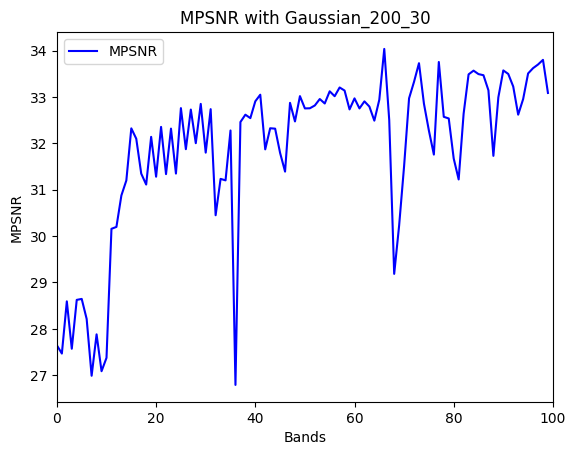

In [ ]:
epochs = range(0, n_epoch)
plt.plot(epochs, psnrs_matric, 'b', label='MPSNR')
plt.title(f'MPSNR with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MPSNR')
plt.legend()
plt.xlim(0,n_epoch)
plt.savefig(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_Graph_MPSNR_{argument_sigma_role}.png')
plt.show()

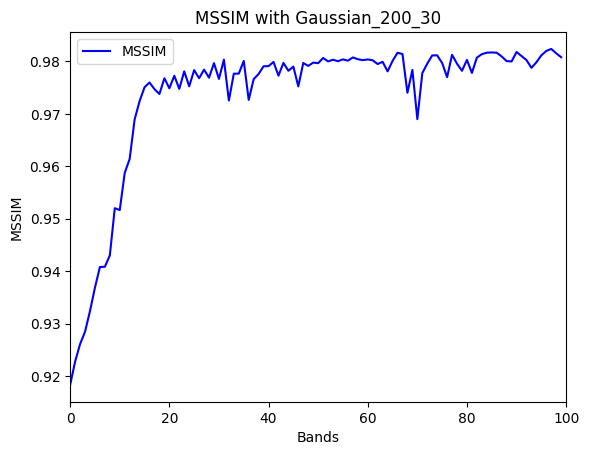

In [ ]:
epochs = range(0, n_epoch)
plt.plot(epochs, ssims_matric, 'b', label='MSSIM')
plt.title(f'MSSIM with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MSSIM')
plt.legend()
plt.xlim(0,n_epoch)
plt.savefig(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_Graph_MSSIM_{argument_sigma_role}.png')
plt.show()

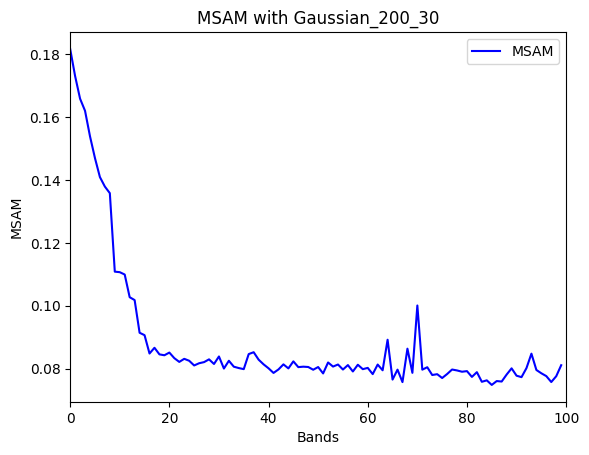

In [ ]:
epochs = range(0, n_epoch)
plt.plot(epochs, sams_matric, 'b', label='MSAM')
plt.title(f'MSAM with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MSAM')
plt.legend()
plt.xlim(0,n_epoch)
plt.savefig(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_Graph_MSAM_{argument_sigma_role}.png')
plt.show()

# Image Prediction

In [ ]:
SEED()

def show_image(data_noise,test_out,data_clean):
  def Noise_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(data_noise[:, :, (56,25,16)])
    plt.savefig(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Noise_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('noise image')
  def Denoise_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(test_out[:, :, (56,25,16)])
    plt.savefig(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Denoise_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('denoise image')
  def Clean_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(data_clean[:, :, (56,25,16)])
    plt.savefig(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Clean_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('clean image')

  Noise_Image()
  Denoise_Image()
  Clean_Image()
  plt.show()

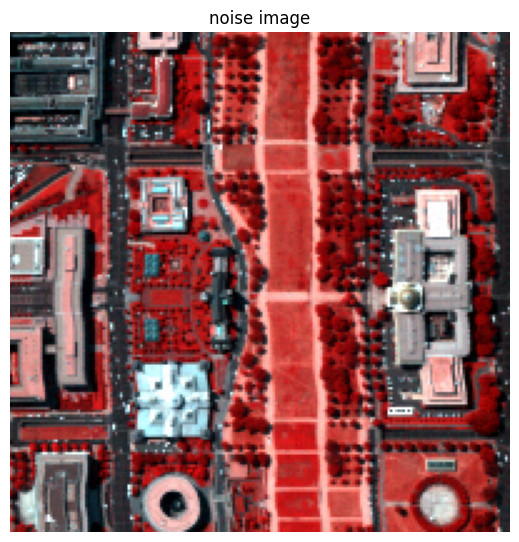

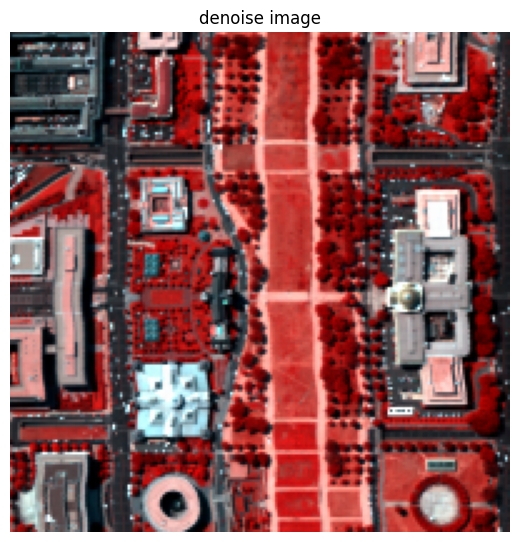

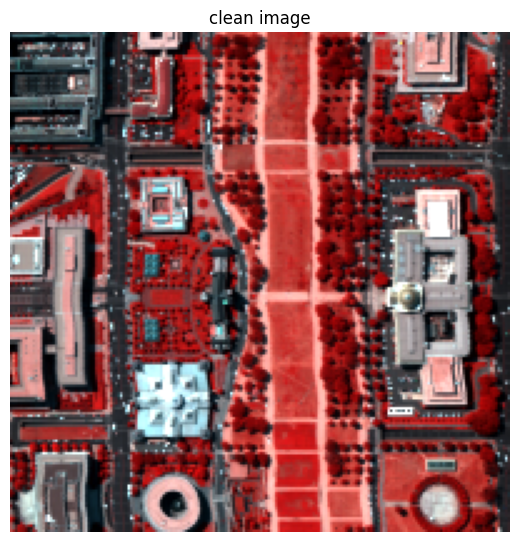

In [ ]:
show_image(test_data_noise_DC,denoise_image_out,test_data_clean_DC)

In [ ]:
SEED()

scipy.io.savemat(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Denoise_{argument_sigma_role}_Dataset_Image.mat",{'Image': denoise_image_out})